In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import torch
print("Torch version:", torch.__version__)

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder, GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from torch.utils.data import Dataset, DataLoader

import sys
import os

Torch version: 2.6.0


# Load Data

In [3]:
# 📍 sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "Sources")))

# 📥 Import load fonction
from data_loader import load_data

#### ✅ Raw Data

In [5]:
df_Copper_Original = load_data('raw', 'Com_Copper.csv')

# 🕒 'Date'in datetime
df_Copper_Original['Date'] = pd.to_datetime(df_Copper_Original['Date'], format='%d/%m/%Y')

# 🔍 vieuw
print(df_Copper_Original.head(2))

✅ Load File : /Users/juniormukenze/Documents/00 Personal Research Publication/Research Paper 1/Enhancing Time Series Forecasting with VAE-based Data Augmentation and Temporal Pattern Analysis using Neural Networks/Modules/data/raw/Com_Copper.csv  |  Separator detected: ';'
    Symbol       Date    Open    High     Low   Close
0  HG1:COM 2024-08-19  4.1500  4.2005  4.1415  4.1805
1  HG1:COM 2024-08-16  4.1425  4.1635  4.0950  4.1435


#### ✅ Generated Data

In [7]:
df_bilstmVAE = load_data('generated', 'SynBilstmVAE.csv')

# 🕒 'Date'in datetime
#df_bilstmVAE['Date'] = pd.to_datetime(df_bilstmVAE['Date'], format='%d/%m/%Y')

# 🔍 vieuw
print(df_bilstmVAE.head(2))

✅ Load File : /Users/juniormukenze/Documents/00 Personal Research Publication/Research Paper 1/Enhancing Time Series Forecasting with VAE-based Data Augmentation and Temporal Pattern Analysis using Neural Networks/Modules/data/generated/SynBilstmVAE.csv  |  Separator detected: ','
         Date      Open      High       Low     Close  Date_from_start  \
0  2024-08-19  2.500406  2.522122  2.481915  2.502785           4165.0   
1  2024-08-16  2.499700  2.522045  2.480236  2.502988           4162.0   

   day_of_week  month group_id  
0          0.0    8.0      Syn  
1          4.0    8.0      Syn  


# Preprocessing

#### ✅ Raw Data

In [10]:
## Extrat dates
copper_dates = df_Copper_Original['Date'].reset_index(drop=True).copy()

df_Copper_Original['Date'] = pd.to_datetime(df_Copper_Original['Date'], format='%d/%m/%Y')
df_Copper_Original = df_Copper_Original.drop(["Symbol"], axis=1)
df_Copper_Original.sort_values('Date', ascending=True, inplace=True)

## Create time_idx using dates
df_Copper_Original['Date_from_start'] = (df_Copper_Original['Date'] - df_Copper_Original['Date'].min()).dt.days

# Create 'day_of_week' (0 = Monday, 6 = Sunday)
df_Copper_Original['day_of_week'] = df_Copper_Original['Date'].dt.dayofweek

# Generate 'month' (1 = janvier, 12 = décembre)
df_Copper_Original['month'] = df_Copper_Original['Date'].dt.month
df_Copper_Original["group_id"] = "Orig"

df_Copper_Original.head(2)

,Date,Open,High,Low,Close,Date_from_start,day_of_week,month,group_id
2833,2013-03-25,3.4705,3.4710,3.430,3.435,0,0,3,Orig
2832,2013-03-27,3.4345,3.4495,3.416,3.435,2,2,3,Orig


In [16]:
df_Copper_Original.shape

(2834, 9)

#### ✅ Generated Data

In [19]:
# Sort Data by Date 
df_bilstmVAE.sort_values('Date', ascending=True, inplace=True)
df_bilstmVAE.head(2)

,Date,Open,High,Low,Close,Date_from_start,day_of_week,month,group_id
2833,2013-03-25,2.560470,2.581697,2.540563,2.560866,0.0,0.0,3.0,Syn
2832,2013-03-27,2.560351,2.577872,2.540430,2.560783,2.0,2.0,3.0,Syn


In [21]:
# Check Shape
df_bilstmVAE.shape, df_Copper_Original.shape

((2834, 9), (2834, 9))

In [23]:
print(type(df_Copper_Original))
print(type(df_bilstmVAE))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


## 1. GMM without Mixture of Data Augmented

In [26]:
# Time Features 
Copper_Data = df_Copper_Original.copy()

Copper_Data['Date'] = pd.to_datetime(Copper_Data['Date'])

Copper_Data.drop(columns=['Date_from_start','day_of_week','month'], inplace=True)
Copper_Data['year'] = Copper_Data['Date'].dt.year
Copper_Data['month'] = Copper_Data['Date'].dt.month
Copper_Data['day'] = Copper_Data['Date'].dt.day
Copper_Data['weekday'] = Copper_Data['Date'].dt.weekday

Copper_Data.shape

(2834, 10)

In [28]:
Copper_Data.head(2)

,Date,Open,High,Low,Close,group_id,year,month,day,weekday
2833,2013-03-25,3.4705,3.4710,3.430,3.435,Orig,2013,3,25,0
2832,2013-03-27,3.4345,3.4495,3.416,3.435,Orig,2013,3,27,2


### 1.1. Normalization and Standardization

In [31]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

# 1. Encoding  'group_id' into numeric
label_encoder1 = LabelEncoder()
Copper_Data['group_id'] = label_encoder1.fit_transform(Copper_Data['group_id'])


In [33]:
# 2. Normalization of 'Open', 'High', 'Low', 'Close'
scaler1 = StandardScaler()
columns_to_normalize = ['Open', 'High', 'Low', 'Close']
Copper_Data[columns_to_normalize] = scaler1.fit_transform(Copper_Data[columns_to_normalize])

In [35]:
Copper_Data.drop(columns=['Date'], inplace=True)
Copper_Data.head(2)

,Open,High,Low,Close,group_id,year,month,day,weekday
2833,0.375645,0.334328,0.362572,0.325786,0,2013,3,25,0
2832,0.324968,0.304504,0.342561,0.325786,0,2013,3,27,2


In [37]:
Copper_Data.shape

(2834, 9)

# GMM Final - Data Augmented

### 2.1. Mixture of Data Augmented

In [42]:
# Concatenation Strategy
Data_Mixed = pd.concat([df_Copper_Original, df_bilstmVAE], axis=0)
Data_Mixed['Date'] = pd.to_datetime(Data_Mixed['Date'])

Data_Mixed.drop(columns=['Date_from_start','day_of_week','month'], inplace=True)
Data_Mixed['year'] = Data_Mixed['Date'].dt.year
Data_Mixed['month'] = Data_Mixed['Date'].dt.month
Data_Mixed['day'] = Data_Mixed['Date'].dt.day
Data_Mixed['weekday'] = Data_Mixed['Date'].dt.weekday

Data_Mixed.shape

(5668, 10)

In [44]:
Data_Mixed.isna().sum()

Date        0
Open        0
High        0
Low         0
Close       0
group_id    0
year        0
month       0
day         0
weekday     0
dtype: int64

### 2.2. Normalization and Standardization

In [47]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

# 1. Encode 'group_id'
label_encoder = LabelEncoder()
Data_Mixed['group_id'] = label_encoder.fit_transform(Data_Mixed['group_id'])

# 2. Normalization of 'Open', 'High', 'Low', 'Close'
scaler = StandardScaler()
columns_to_normalize = ['Open', 'High', 'Low', 'Close']
Data_Mixed[columns_to_normalize] = scaler.fit_transform(Data_Mixed[columns_to_normalize])

In [49]:
Data_Mixed.shape

(5668, 10)

In [51]:
# Copy 'Date' 
date_copy = Data_Mixed['Date'].copy()

# Drop 'Date' from DataFrame
Data_Mixed.drop(columns=['Date'], inplace=True)
Data_Mixed.shape

(5668, 9)

In [53]:
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

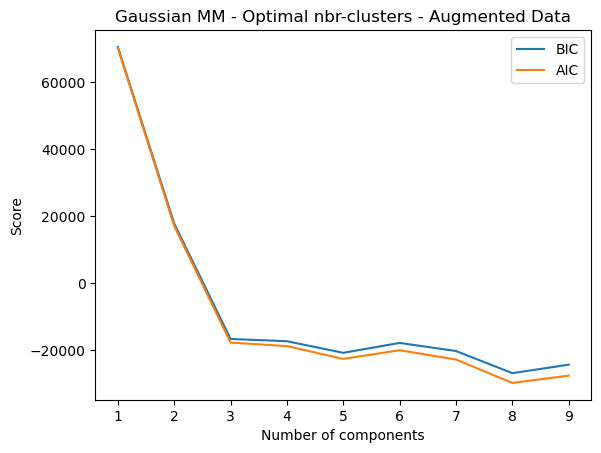

In [54]:
bic = []
aic = []
n_components = range(1, 10)

for n in n_components:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(Data_Mixed)
    bic.append(gmm.bic(Data_Mixed))
    aic.append(gmm.aic(Data_Mixed))

plt.plot(n_components, bic, label='BIC')
plt.plot(n_components, aic, label='AIC')
plt.legend()
plt.xlabel("Number of components")
plt.ylabel("Score")
plt.title("Gaussian MM - Optimal nbr-clusters - Augmented Data")
plt.show()


### GMM Clusters Optimal

In [57]:
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
gmm.fit(Data_Mixed)

# Predict Clusters
Data_Mixed['Cluster_Label'] = gmm.predict(Data_Mixed)


### Save Data_Mixed clustered

In [59]:
# 🔧 Chemin vers la racine du projet
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))

# 📁 Target Folder
EXPORT_DIR = os.path.join(ROOT_DIR, "data", "cluster")

# ✅ Création du dossier s’il n’existe pas
os.makedirs(EXPORT_DIR, exist_ok=True)

# 📄 Export files path
filename = "Copper_Data_GMMix.csv"
export_path = os.path.join(EXPORT_DIR, filename)

# 💾 Export files
Data_Mixed.to_csv(export_path, index=False)
print(f"✅ Dataset exporté avec succès sous : {export_path}")

✅ Dataset exporté avec succès sous : /Users/juniormukenze/Documents/00 Personal Research Publication/Research Paper 1/Enhancing Time Series Forecasting with VAE-based Data Augmentation and Temporal Pattern Analysis using Neural Networks/Modules/data/cluster/Copper_Data_GMMix.csv


In [60]:
Data_Mixed.head(2)

,Open,High,Low,Close,group_id,year,month,day,weekday,Cluster_Label
2833,0.393996,0.350258,0.380149,0.340854,0,2013,3,25,0,0
2832,0.340330,0.318698,0.358946,0.340854,0,2013,3,27,2,0


In [61]:
Data_Mixed['Cluster_Label'].unique()

array([0, 1, 2])

# Gaussian Mixture on Originale Data

In [69]:
Copper_Data.head(2)

,Open,High,Low,Close,group_id,year,month,day,weekday
2833,0.375645,0.334328,0.362572,0.325786,0,2013,3,25,0
2832,0.324968,0.304504,0.342561,0.325786,0,2013,3,27,2


In [71]:
Copper_copy = Copper_Data.copy()

label_encoder2 = LabelEncoder()
Copper_copy['group_id'] = label_encoder2.fit_transform(Copper_copy['group_id'])
Copper_copy.shape

(2834, 9)

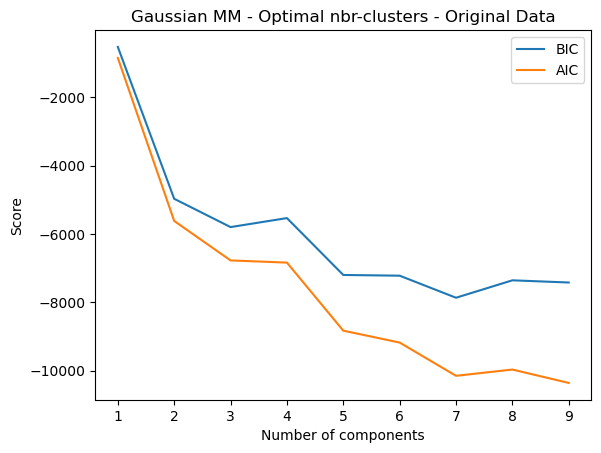

In [73]:
bic = []
aic = []
n_components = range(1, 10)

for n in n_components:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(Copper_copy)
    bic.append(gmm.bic(Copper_copy))
    aic.append(gmm.aic(Copper_copy))

plt.plot(n_components, bic, label='BIC')
plt.plot(n_components, aic, label='AIC')
plt.legend()
plt.xlabel("Number of components")
plt.ylabel("Score")
plt.title("Gaussian MM - Optimal nbr-clusters - Original Data")
plt.show()

In [75]:
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
gmm.fit(Copper_copy)

Copper_copy['Cluster_Label'] = gmm.predict(Copper_copy)

In [76]:
# 📄 Name of exported file
filename = "Copper_Data_GMM_O.csv"
export_path = os.path.join(EXPORT_DIR, filename)

# 💾 Name file saved
Data_Mixed.to_csv(export_path, index=False)
print(f"✅ Dataset exporté avec succès sous : {export_path}")

✅ Dataset exporté avec succès sous : /Users/juniormukenze/Documents/00 Personal Research Publication/Research Paper 1/Enhancing Time Series Forecasting with VAE-based Data Augmentation and Temporal Pattern Analysis using Neural Networks/Modules/data/cluster/Copper_Data_GMM_O.csv
